# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash 
pip install lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

Dont forget to setup your LLM API key. You can also pass it to the llm object directly. 

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```


## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset. 


- **Multiple LLM Backends**: LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `llm` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python
lida = Manager(text_gen = llm(provider="hf", model="TheBloke/gpt4-x-vicuna-13B-HF", device_map="auto"))
lida = Manager(text_gen = llm("openai")) 
lida = Manager(text_gen = llm("cohere")) 
```
- **Summarization Methods**: The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm. 
- **Caching**: Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.




In [1]:
# !pip install lida 
# !pip install lida[infographics] # for infographics support

In [2]:
from lida import Manager, TextGenerationConfig , llm 
from lida.utils import plot_raster 

## Summarize Data, Generate Goals

In [3]:
lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="default", textgen_config=textgen_config)  
goals = lida.goals(summary, n=1, textgen_config=textgen_config)
print(goals)

[Goal(index=0, question='What is the distribution of Retail_Price and Dealer_Cost?', visualization='histogram of Retail_Price and Dealer_Cost', rationale='This tells us about the range and distribution of prices and costs of cars in the dataset.')]


## Generate Visualizations

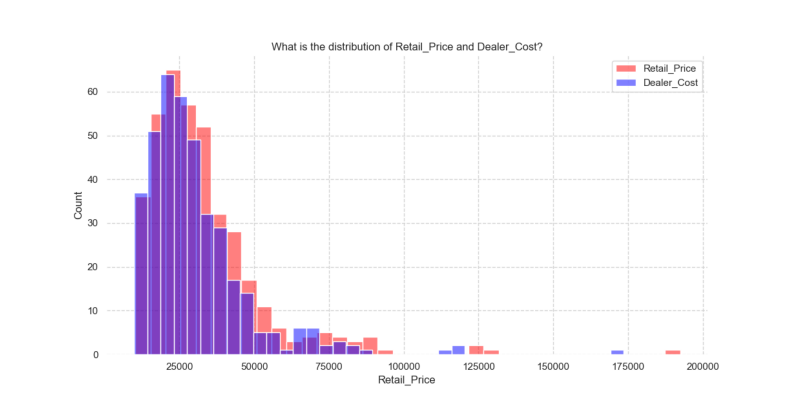

In [4]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library) 
# plot raster image of chart
plot_raster(charts[0].raster) 

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

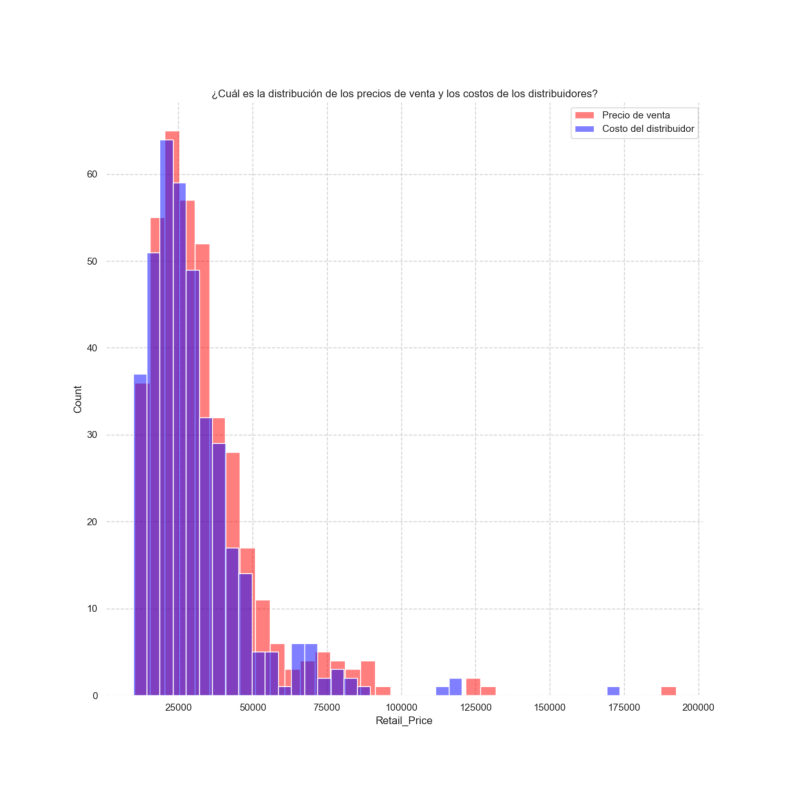

In [5]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["zoom in 50%", "make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
plot_raster(edited_charts[0].raster)

## Visualization explanations and accessibility

In [6]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The chart is a histogram plot created using the seaborn library. The chart shows the distribution of two variables, Retail_Price and Dealer_Cost, using different colors to differentiate between them. The goal of the chart is to compare the distribution of the two variables and identify any patterns or differences between them. The chart is easy to read and understand, with clear labels and a legend to explain the colors used.
transformation  **  There is no data transformation in this code. The plot function takes a pandas DataFrame as input and uses it to create the histogram plot.
visualization  **  The code first sets the style of the plot to 'whitegrid' using the seaborn set function. It then creates a figure and axis object using the subplots function from matplotlib, with a size of 12 by 6 inches. Two histograms are then created using the histplot function from seaborn, one for the Retail_Price variable and one for the Dealer_Cost variable. The Retail_Price his

## Visualization code self-evaluation and repair

In [7]:
evaluations = lida.evaluate(code=code,  goal=goals[i], library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 There are no bugs, syntax errors, or typos in the code. The code should compile without any issues.
	**********************************
transformation Score 10 / 10
	 The data is not transformed in any way, but it is appropriately filtered by the x-axis variables Retail_Price and Dealer_Cost.
	**********************************
compliance Score 10 / 10
	 The code meets the specified visualization goals of showing the distribution of Retail_Price and Dealer_Cost.
	**********************************
type Score 10 / 10
	 The histogram is an appropriate visualization type for showing the distribution of continuous variables like Retail_Price and Dealer_Cost.
	**********************************
encoding Score 10 / 10
	 The data is encoded appropriately with the x-axis variables Retail_Price and Dealer_Cost.
	**********************************
aesthetics Score 10 / 10
	 The aesthetics of the visualization are appropriate for a histogram, with different colors for each va

## Visualization Recommendation

In [8]:
import json 

dstring = """['import seaborn as sns\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndef plot(data: pd.DataFrame):\n    # solution code\n    plt.figure(figsize=(10, 6))\n    sns.scatterplot(data=data, x="Retail_Price", y="Horsepower_HP_", hue="Type", style="AWD")\n    plt.title("What is the relationship between Retail_Price, Horsepower_HP_ and Type?", wrap=True)\n    plt.xlabel("Retail Price")\n    plt.ylabel("Horsepower_HP_")\n    plt.tight_layout()\n    return plt\n\nchart = plot(data)']"""
# d0 = json.loads(dstring)

In [9]:
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=data, x="Type", y="Retail_Price", hue="AWD")
    plt.title('What is the distribution of Retail_Price by Type and AWD?', wrap=True)
    plt.legend()
    return plt;
    
chart = plot(data)
****
 name 'sns' is not defined
seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=data, x="Type", y="Retail_Price", hue="AWD")
    plt.title('What is the distribution of Retail_Price by Type and AWD?', wrap=True)
    plt.legend()
    return plt;
    
chart = plot(data)
****
 name 'sns' is not defined


In [10]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    # print(chart.code, "\n====================\n")  
    # plot raster image of chart
    plot_raster(chart.raster) 
    pass

Recommended 0 charts


## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [11]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [12]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, rain drops, highly detailed, no blur, white background")

/home/victordibia/miniconda3/envs/coral/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 27 files: 100%|██████████| 27/27 [00:00<00:00, 179755.89it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Resizing init_image to (512, 512).
100%|██████████| 31/31 [00:01<00:00, 16.64it/s]


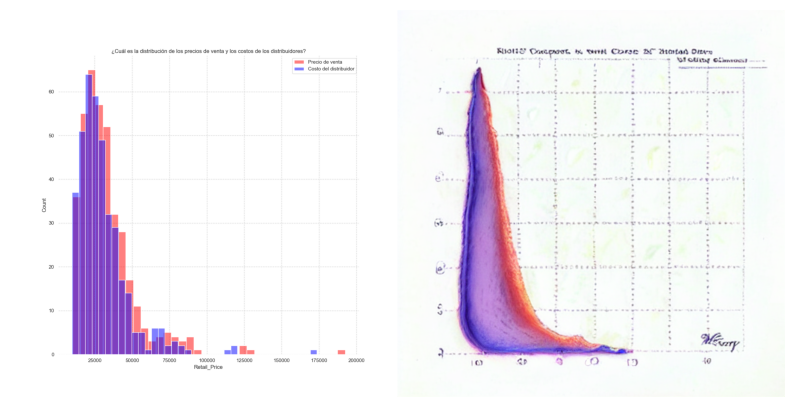

In [13]:
plot_raster([edited_charts[0].raster, infographics["images"][0]]) 